In [52]:
# 와인데이터

분류 모델
- target = quality
- feature = quality와의 상관계수가 0.10이 넘는 컬럼들.

In [53]:
import pandas as pd
import numpy as np
import torch

In [54]:
file = '../data/winequality-white.csv'

In [55]:
# 데이터 프레임 생성.
wineDF = pd.read_csv(file,  delimiter=';') # ;로 구분자 지정.

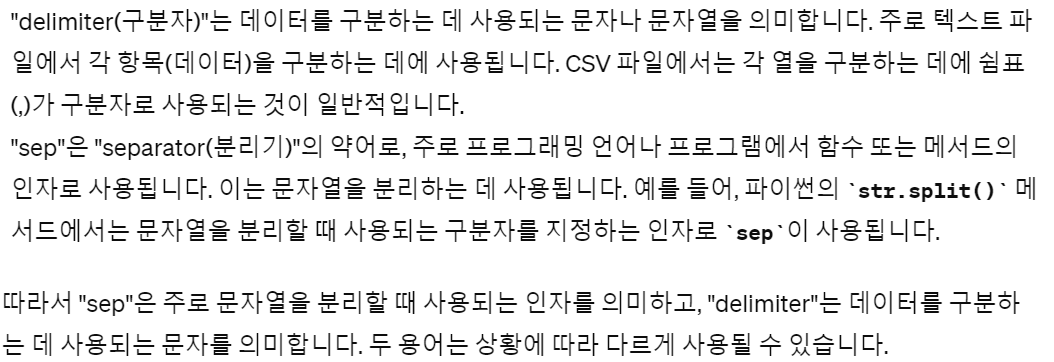

In [56]:
# 데이터 확인
wineDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [57]:
wineDF.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [58]:
# 결측치 확인 => 없음.
wineDF.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [59]:
# 중복값 확인 => 937개 (일단.. 같은 등급의 와인의 경우 점수가 같을 수 있다고 가정하고 패스..;;)
wineDF.duplicated().sum()

937

In [60]:
# target으로 사용할 quality 컬럼과 나머지 컬럼 간의 상관계수 확인. (절댓값 씌워서 내림차순 정렬.)
# => alcohol과 density 열이 상관계수가 상대적으로 높음을 확인.
abs(wineDF.corr()['quality']).sort_values(ascending=False)

quality                 1.000000
alcohol                 0.435575
density                 0.307123
chlorides               0.209934
volatile acidity        0.194723
total sulfur dioxide    0.174737
fixed acidity           0.113663
pH                      0.099427
residual sugar          0.097577
sulphates               0.053678
citric acid             0.009209
free sulfur dioxide     0.008158
Name: quality, dtype: float64

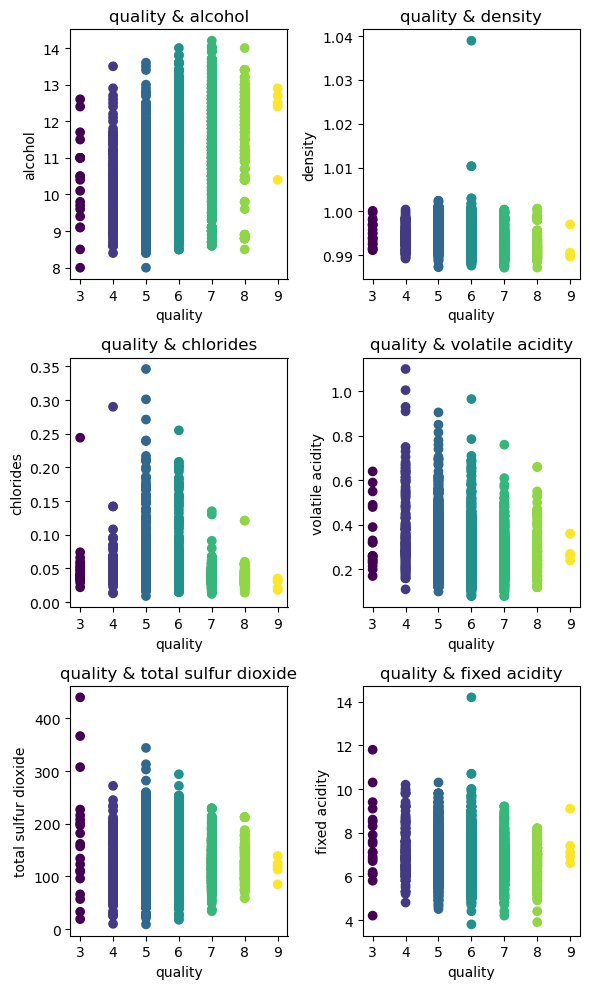

In [70]:
# 데이터 시각화 (분포 확인) -> 박스플롯으로 봤어야.....;;;;
import matplotlib.pyplot as plt

columns = ['alcohol', 'density', 'chlorides', 'volatile acidity', 'total sulfur dioxide', 'fixed acidity']

n = 1
plt.figure(figsize=(6,10))
for col in columns :
    plt.subplot(3, 2, n)
    plt.scatter(wineDF['quality'], wineDF[col], c=wineDF['quality'])
    plt.title(f'quality & {col}')
    plt.xticks(wineDF['quality'].unique())
    plt.xlabel('quality')
    plt.ylabel(f'{col}')
    if n > 6 :
        break
    n += 1
plt.tight_layout()
plt.show()    

In [84]:
# 데이터 분리
featureDF = wineDF[columns]
targetSR = wineDF['quality']

# 이진 분류 모델로 만들기 위해 3~5까지를 0으로 만들고 6~9까지를 1로 변환. ===> LabelEncoder()
targetSR = targetSR.replace({3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:1})
targetSR

0       1
1       1
2       1
3       1
4       1
       ..
4893    1
4894    0
4895    1
4896    1
4897    1
Name: quality, Length: 4898, dtype: int64

In [85]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(featureDF, targetSR, test_size=0.2, stratify=targetSR, random_state=13) # random_state 쓰기 까먹지 않기..;;

In [86]:
# 데이터 전처리 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # -1 ~ 1
scaler.fit(Xtrn)

scaled_Xtrn = scaler.transform(Xtrn)
scaled_Xtst = scaler.transform(Xtst)


In [87]:
# 모듈 로딩 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [88]:
# 랜덤 시드 설정
torch.manual_seed(1)

torchXtrn = torch.FloatTensor(scaled_Xtrn)
torchYtrn = torch.FloatTensor(ytrn)
torchXtrn, torchYtrn

(tensor([[-1.2284,  0.2397,  0.7081,  0.8156, -0.1121, -0.4227],
         [ 0.5559, -1.1197, -0.1255, -1.4775,  0.1690, -0.6634],
         [-0.6607,  1.1737,  0.2450,  0.6162,  0.6608,  0.4198],
         ...,
         [-0.3363, -0.4549,  0.2913,  0.2174,  1.0824, -0.7838],
         [-0.9040,  1.4030,  0.2913, -0.3808,  0.0987, -0.3024],
         [-0.2957, -0.6145, -0.7275, -0.9291, -0.3697, -1.9873]]),
 tensor([1., 1., 0.,  ..., 0., 1., 1.]))

In [95]:
# 모델 설계
mdl = nn.Sequential( #순차적인 레이어들을 연결하여 모델을 정의
    nn.Linear(6, 1), #선형 레이어(linear layer)를 정의, 입력특성(feature)= 6 / 출력특성 = 1
    nn.Sigmoid())

# optimizer 설정
optimizer = optim.SGD(mdl.parameters(), lr=1) 
# optim.SGD : 확률적 경사 하강법(SGD) 옵티마이저
# model.parameters(): 이 부분은 최적화할 모델의 파라미터를 지정
# lr=1: 학습률(learning rate)을 1로 설정.
# 학습률 : 한 번의 최적화 단계에서 파라미터를 조정하는 양을 결정하는 하이퍼파라미터

In [96]:
# def training():
#     nb_epochs = 1000 # [처음----끝] * 1000 학습.
#     for epoch in range(nb_epochs + 1): # 에포크만큼 반복.
#         # 모델(mdl)의 예측값 H(x) 계산
#         hypothesis = mdl(torchXtrn)

#         # cost 계산 => 이진 분류 손실함수 binary_cross_entropy()
#         # 손실 함수 --> 모델이 예측한 값과 실제 값 사이의 차이를 계산
#         # 모델이 1을 예측하는 경우 (긍정 클래스에 속한다고 예측한 경우), 모델이 0을 예측하는 경우 (부정 클래스에 속한다고 예측한 경우) 두 경우 모두의 손실을 계산하여
#         # 최종 손실을 계산한다.
#         cost = F.binary_cross_entropy(hypothesis, torchYtrn) 

#         optimizer.zero_grad() #  옵티마이저에 할당된 모든 모델 파라미터의 변화도(gradient)를 초기화
#         cost.backward() # 역전파 수행 (각 파라미터에 대한 기울기를 계산)
#         optimizer.step() # 옵티마이저가 각 파라미터를 업데이트

#         # 20번마다 로그 출력
#         if epoch % 10 == 0: # 10번 학습할 때마다
#             prediction = hypothesis >= torch.FloatTensor([0.5])     # 예측값이 0.5를 넘으면 True로 간주
#             correct_prediction = prediction.float() == torchYtrn      # 전체 예측값 : 실제값과 일치하는 경우만 True로 간주 (일치하지 않으면 False)
#             accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도(accuracy) = (실제값과 일치하는 경우(True=1인 경우) 개수 /전체 예측값의 개수)

#             print(f'Epoch {epoch:4d}/{nb_epochs} Cost: {cost.item():.6f} Accuracy {accuracy * 100:2.2f}%')
# ==> 이렇게 했더니 오류(ValueError: Using a target size (torch.Size([3918])) that is different to the input size (torch.Size([3918, 1])) is deprecated.) 발생.
# => unsqueeze를 사용해서 차원을 늘려보았음.

In [97]:
torchYtrn = torchYtrn.unsqueeze(dim=1)

In [101]:
def training():
    nb_epochs = 1000 # [처음----끝] * 1000 학습.
    for epoch in range(nb_epochs + 1): # 에포크만큼 반복.
        # 모델(mdl)의 예측값 H(x) 계산
        hypothesis = mdl(torchXtrn)

        # cost 계산 => 이진 분류 손실함수 binary_cross_entropy()
        # 손실 함수 --> 모델이 예측한 값과 실제 값 사이의 차이를 계산
        # 모델이 1을 예측하는 경우 (긍정 클래스에 속한다고 예측한 경우), 모델이 0을 예측하는 경우 (부정 클래스에 속한다고 예측한 경우) 두 경우 모두의 손실을 계산하여
        # 최종 손실을 계산한다.
        cost = F.binary_cross_entropy(hypothesis, torchYtrn) 

        optimizer.zero_grad() #  옵티마이저에 할당된 모든 모델 파라미터의 변화도(gradient)를 초기화
        cost.backward() # 역전파 수행 (각 파라미터에 대한 기울기를 계산)
        optimizer.step() # 옵티마이저가 각 파라미터를 업데이트

        # 20번마다 로그 출력
        if epoch % 10 == 0: # 10번 학습할 때마다
            prediction = hypothesis >= torch.FloatTensor([0.5])     # 예측값이 0.5를 넘으면 True로 간주
            correct_prediction = prediction.float() == torchYtrn      # 전체 예측값 : 실제값과 일치하는 경우만 True로 간주 (일치하지 않으면 False)
            accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도(accuracy) = (실제값과 일치하는 경우(True=1인 경우) 개수 /전체 예측값의 개수)

            print(f'Epoch {epoch:4d}/{nb_epochs} Cost: {cost.item():.6f} Accuracy {accuracy * 100:2.2f}%')

In [99]:
training() # 왜...왜...?

Epoch    0/1000 Cost: 0.714915 Accuracy 46.45%
Epoch   10/1000 Cost: 0.529137 Accuracy 73.33%
Epoch   20/1000 Cost: 0.519979 Accuracy 74.07%
Epoch   30/1000 Cost: 0.516495 Accuracy 74.37%
Epoch   40/1000 Cost: 0.514785 Accuracy 74.76%
Epoch   50/1000 Cost: 0.513910 Accuracy 74.94%
Epoch   60/1000 Cost: 0.513442 Accuracy 74.96%
Epoch   70/1000 Cost: 0.513183 Accuracy 74.89%
Epoch   80/1000 Cost: 0.513035 Accuracy 74.91%
Epoch   90/1000 Cost: 0.512950 Accuracy 75.01%
Epoch  100/1000 Cost: 0.512900 Accuracy 75.06%
Epoch  110/1000 Cost: 0.512870 Accuracy 75.09%
Epoch  120/1000 Cost: 0.512853 Accuracy 75.06%
Epoch  130/1000 Cost: 0.512843 Accuracy 75.06%
Epoch  140/1000 Cost: 0.512836 Accuracy 75.04%
Epoch  150/1000 Cost: 0.512833 Accuracy 75.04%
Epoch  160/1000 Cost: 0.512830 Accuracy 75.04%
Epoch  170/1000 Cost: 0.512829 Accuracy 75.09%
Epoch  180/1000 Cost: 0.512828 Accuracy 75.09%
Epoch  190/1000 Cost: 0.512828 Accuracy 75.09%
Epoch  200/1000 Cost: 0.512828 Accuracy 75.09%
Epoch  210/10

In [102]:
# 학습 후 W, b 확인
print(list(mdl.parameters()))

[Parameter containing:
tensor([[ 1.4436,  0.4481, -0.0352, -0.7053,  0.0169, -0.1934]],
       requires_grad=True), Parameter containing:
tensor([0.8970], requires_grad=True)]
